In [1]:
%matplotlib inline
import itertools
import numpy as np
import numpy.random as rnd
import time
import gpflow
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
from gpflow.ci_utils import ci_niter
plt.style.use('ggplot')
import os

import sys
sys.path.append('../code')
from dgp import DGP

gpflow.config.set_default_summary_fmt('notebook')
np.random.seed(0)
tf.random.set_seed(0)

## Load Data

In [2]:
!wget --no-check-certificate \
    http://www.iro.umontreal.ca/~lisa/icml2007data/rectangles_images.zip \
    -O /tmp/rectangles_images.zip
import zipfile
local_zip = '/tmp/rectangles_images.zip' # local path of downloaded .zip file
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp') # contents are extracted to '/tmp' folder
zip_ref.close()

--2020-02-12 20:23:41--  http://www.iro.umontreal.ca/~lisa/icml2007data/rectangles_images.zip
Resolving www.iro.umontreal.ca (www.iro.umontreal.ca)... 132.204.26.36
Connecting to www.iro.umontreal.ca (www.iro.umontreal.ca)|132.204.26.36|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85344876 (81M) [application/zip]
Saving to: ‘/tmp/rectangles_images.zip’

/tmp/rectangles_ima 100%[===================>]  81.39M  10.6MB/s    in 13s     

2020-02-12 20:23:54 (6.32 MB/s) - ‘/tmp/rectangles_images.zip’ saved [85344876/85344876]



In [2]:
data_path = '/tmp'
train_file, test_file = [os.path.join(data_path,
                                      'rectangles_im_' + ds + '.amat') 
                         for ds in ['train','test']]

In [3]:
def load_data(filename):
    file = open(filename,'rt')
    x = np.array([line.split()[:-1] for line in file.readlines()], np.float64)
    file = open(filename,'rt')
    y = np.array([0 if line.split()[-1]=='0.0000000e+00' else 1 for line in file.readlines()], np.int32)
    return x,y

x_train, y_train = load_data(train_file)
x_test, y_test = load_data(test_file)

In [4]:
y_train = np.reshape(y_train,(-1,1))
y_test = np.reshape(y_test,(-1,1))

In [5]:
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(12000, 784) (50000, 784)
(12000, 1) (50000, 1)


In [6]:
minibatch_size = 1000
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).repeat().shuffle(10000)

In [7]:
N = x_train.shape[0]
D = x_train.shape[1]

## Define SVGP and DGP model

In [8]:
from scipy.stats import mode
from scipy.cluster.vq import kmeans2

# number of inducing points
M = 100
Z = kmeans2(x_train,M,minit='points')[0]

In [9]:
likelihood = gpflow.likelihoods.Bernoulli()
kernel = gpflow.kernels.SquaredExponential(variance=2., lengthscale=5.)

In [10]:
m = gpflow.models.SVGP(kernel=kernel, likelihood=likelihood,
    inducing_variable=Z, num_latent=1, whiten=True, q_diag=True)

In [11]:
Z_500 = kmeans2(x_train,500,minit='points')[0]
m_500 = gpflow.models.SVGP(kernel=kernel, likelihood=likelihood,
    inducing_variable=Z_500, num_latent=1, whiten=True, q_diag=True)

In [110]:
def make_DGP(L):
    kernels = []
    for l in range(L):
        k = gpflow.kernels.SquaredExponential(variance=2., lengthscale=5.)
        kernels.append(k)
    dims = [784,]
    for l in range(L-1):
        dims.append(30)
    dims.append(1)
        
    m_dgp = DGP(x_train, y_train, Z, dims, kernels, likelihood,
                white=True, num_samples=1, num_data=N, minibatch_size=minibatch_size)
    
#     Initialise the layers to near deterministic
    for layer in m_dgp.layers[:-1]:
        layer.q_sqrt = gpflow.base.Parameter(layer.q_sqrt.value() * 1e-5, 
                                 transform=gpflow.utilities.triangular())
    print(dims)
    return m_dgp

In [13]:
def make_DGP_ARD(L):
    dims = [784,]
    for l in range(L-1):
        dims.append(30)
    dims.append(1)
    
    kernels = []
    for dim in dims[:-1]:
        k = gpflow.kernels.SquaredExponential(variance=2., lengthscale=[2.]*dim)
        kernels.append(k)
    
        
    m_dgp = DGP(x_train, y_train, Z, dims, kernels, likelihood,
                white=True, num_samples=1, num_data=N, minibatch_size=minibatch_size)
    
#     Initialise the layers to near deterministic
    for layer in m_dgp.layers[:-1]:
        layer.q_sqrt = gpflow.base.Parameter(layer.q_sqrt.value() * 1e-5, 
                                 transform=gpflow.utilities.triangular())
    print(dims)
    return m_dgp

In [111]:
dgp2 = make_DGP(2)

[784, 30, 1]


In [40]:
dgp2_ard = make_DGP_ARD(2)
dgp3_ard = make_DGP_ARD(3)

[784, 30, 1]
[784, 30, 30, 1]


In [96]:
dgp3 = make_DGP(3)

[784, 30, 30, 1]


In [103]:
dgp3_50 = make_DGP(3)

[784, 30, 30, 1]


In [143]:
dgp3_adam = make_DGP(3)

[784, 30, 30, 1]


In [90]:
dgp4 = make_DGP(4)

[784, 30, 30, 30, 1]


In [147]:
dgp4_adam = make_DGP(4)

[784, 30, 30, 30, 1]


In [175]:
gpflow.utilities.print_summary(m, fmt='notebook')

name,class,transform,trainable,shape,dtype,value
SVGP.kernel.variance,Parameter,Softplus,True,(),float64,2.0
SVGP.kernel.lengthscale,Parameter,Softplus,True,(),float64,5.0
SVGP.inducing_variable.Z,Parameter,,True,"(100, 784)",float64,"[[0.33137255, 0.32838875, 0.33034953..."
SVGP.q_mu,Parameter,,True,"(100, 1)",float64,[[0....
SVGP.q_sqrt,Parameter,Softplus,True,"(100, 1)",float64,[[1....


In [156]:
gpflow.utilities.print_summary(m_500, fmt='notebook')

name,class,transform,trainable,shape,dtype,value
SVGP.kernel.variance,Parameter,Softplus,True,(),float64,0.11993149237214155
SVGP.kernel.lengthscale,Parameter,Softplus,True,(),float64,5.915717792008286
SVGP.inducing_variable.Z,Parameter,,True,"(500, 784)",float64,"[[0.46576191, 0.48899682, 0.49835335..."
SVGP.q_mu,Parameter,,True,"(500, 1)",float64,[[-5.22500141e-02...
SVGP.q_sqrt,Parameter,Softplus,True,"(500, 1)",float64,[[0.1960269...


In [112]:
gpflow.utilities.print_summary(dgp2, fmt='notebook')

name,class,transform,trainable,shape,dtype,value
DGP.layers[0].q_mu,Parameter,,True,"(100, 30)",float64,"[[0., 0., 0...."
DGP.layers[0].q_sqrt,Parameter,FillTriangular,True,"(30, 100, 100)",float64,"[[[1.e-05, 0.e+00, 0.e+00..."
DGP.layers[0].inducing_points.Z,Parameter,,True,"(100, 784)",float64,"[[0.34771242, 0.3382076, 0.33477346..."
DGP.layers[0].kernel.variance,Parameter,Softplus,True,(),float64,2.0
DGP.layers[0].kernel.lengthscale,Parameter,Softplus,True,(),float64,5.0
DGP.layers[0].mean_function.A,Parameter,,False,"(784, 30)",float64,"[[-0.03626653, -0.03429942, 0.0483595..."
DGP.layers[0].mean_function.b,Parameter,,False,"(1,)",float64,[0.]
DGP.layers[1].q_mu,Parameter,,True,"(100, 1)",float64,[[0....
DGP.layers[1].q_sqrt,Parameter,FillTriangular,True,"(1, 100, 100)",float64,"[[[1., 0., 0...."
DGP.layers[1].inducing_points.Z,Parameter,,True,"(100, 30)",float64,"[[-9.75489606e+00, -1.73553149e+00, -1.52179250e+00..."


In [33]:
gpflow.utilities.print_summary(dgp2, fmt='notebook')

name,class,transform,trainable,shape,dtype,value
DGP.layers[0].q_mu,Parameter,,True,"(50, 30)",float64,"[[2.27143786, 0.09974037, -0.40408215..."
DGP.layers[0].q_sqrt,Parameter,FillTriangular,True,"(30, 50, 50)",float64,"[[[0.32811004, 0., 0...."
DGP.layers[0].inducing_points.Z,Parameter,,True,"(50, 784)",float64,"[[1.12692882, 0.95909286, 1.22838387..."
DGP.layers[0].kernel.variance,Parameter,Softplus,True,(),float64,2.331352728663176
DGP.layers[0].kernel.lengthscale,Parameter,Softplus,True,(),float64,16.149704381994326
DGP.layers[0].mean_function.A,Parameter,,False,"(784, 30)",float64,"[[-0.03626653, -0.03429942, 0.0483595..."
DGP.layers[0].mean_function.b,Parameter,,False,"(1,)",float64,[0.]
DGP.layers[1].q_mu,Parameter,,True,"(50, 1)",float64,[[0.20433731...
DGP.layers[1].q_sqrt,Parameter,FillTriangular,True,"(1, 50, 50)",float64,"[[[0.14096995, 0., 0...."
DGP.layers[1].inducing_points.Z,Parameter,,True,"(50, 30)",float64,"[[-15.4105648, 1.26860044, -0.10526466..."


In [185]:
gpflow.utilities.print_summary(dgp2_ard, fmt='notebook')

name,class,transform,trainable,shape,dtype,value
DGP.layers[0].q_mu,Parameter,,True,"(100, 30)",float64,"[[0.58523674, 0.34974512, -0.04716433..."
DGP.layers[0].q_sqrt,Parameter,FillTriangular,True,"(30, 100, 100)",float64,"[[[2.02569840e-01, 0.00000000e+00, 0.00000000e+00..."
DGP.layers[0].inducing_points.Z,Parameter,,True,"(100, 784)",float64,"[[0.42256769, 0.43536203, 0.47497946..."
DGP.layers[0].kernel.variance,Parameter,Softplus,True,(),float64,0.17692920954976846
DGP.layers[0].kernel.lengthscale,Parameter,Softplus,True,"(784,)",float64,"[10.47164264, 10.94599033, 10.76220985..."
DGP.layers[0].mean_function.A,Parameter,,False,"(784, 30)",float64,"[[-0.03626653, -0.03429942, 0.0483595..."
DGP.layers[0].mean_function.b,Parameter,,False,"(1,)",float64,[0.]
DGP.layers[1].q_mu,Parameter,,True,"(100, 1)",float64,[[2.38412736...
DGP.layers[1].q_sqrt,Parameter,FillTriangular,True,"(1, 100, 100)",float64,"[[[0.58817656, 0., 0...."
DGP.layers[1].inducing_points.Z,Parameter,,True,"(100, 30)",float64,"[[-15.37682052, -2.18436687, -5.25553959..."


In [186]:
dgp2_ard.layers[0].kernel.lengthscale

<tf.Tensor: id=197425413, shape=(784,), dtype=float64, numpy=
array([10.47164264, 10.94599033, 10.76220985, 10.93497579, 11.23854883,
       10.89745549, 10.25039896, 10.66902026, 10.5386202 , 10.09551118,
       10.08440274,  9.11412653,  8.61568744,  8.99907451,  4.86947802,
        4.64821102,  7.38468017,  7.52157106,  7.43003448,  8.37274605,
        9.36442098, 10.38022668, 10.20515945,  9.82188471, 11.01563425,
       11.21198407, 10.92692732, 10.56797782, 11.16722231, 10.94935882,
       11.01194579, 10.53266584, 10.82259212, 10.32216926, 10.48291343,
       10.89525139, 10.68852551,  9.88483813, 10.70975785, 10.58312378,
       10.31164752, 10.04712524, 10.58472597, 10.87713824, 10.97734496,
       10.81360436, 10.95655566, 10.67622088, 10.77791754, 10.89429728,
       10.02577365, 10.01535046, 10.01421891, 10.65664966, 11.03848659,
       10.78946777, 11.25053591, 10.83460329, 10.60910992, 10.77993157,
       10.63947169,  9.51266169,  9.57449187, 10.6740585 ,  9.90663058,
  

In [97]:
gpflow.utilities.print_summary(dgp3, fmt='notebook')

name,class,transform,trainable,shape,dtype,value
DGP.layers[0].q_mu,Parameter,,True,"(100, 30)",float64,"[[0., 0., 0...."
DGP.layers[0].q_sqrt,Parameter,FillTriangular,True,"(30, 100, 100)",float64,"[[[1.e-05, 0.e+00, 0.e+00..."
DGP.layers[0].inducing_points.Z,Parameter,,True,"(100, 784)",float64,"[[0.49729225, 0.46535948, 0.43744164..."
DGP.layers[0].kernel.variance,Parameter,Softplus,True,(),float64,2.0
DGP.layers[0].kernel.lengthscale,Parameter,Softplus,True,(),float64,5.0
DGP.layers[0].mean_function.A,Parameter,,False,"(784, 30)",float64,"[[-0.03626653, -0.03429942, 0.0483595..."
DGP.layers[0].mean_function.b,Parameter,,False,"(1,)",float64,[0.]
DGP.layers[1].q_mu,Parameter,,True,"(100, 30)",float64,"[[0., 0., 0...."
DGP.layers[1].q_sqrt,Parameter,FillTriangular,True,"(30, 100, 100)",float64,"[[[1.e-05, 0.e+00, 0.e+00..."
DGP.layers[1].inducing_points.Z,Parameter,,True,"(100, 30)",float64,"[[-1.78564470e+01, 4.73352204e+00, 1.37455340e+00..."


In [74]:
gpflow.utilities.print_summary(dgp3, fmt='notebook')

name,class,transform,trainable,shape,dtype,value
DGP.layers[0].q_mu,Parameter,,True,"(50, 30)",float64,"[[0.08388305, -0.00455128, 0.02131329..."
DGP.layers[0].q_sqrt,Parameter,FillTriangular,True,"(30, 50, 50)",float64,"[[[3.59987088e-01, 0.00000000e+00, 0.00000000e+00..."
DGP.layers[0].inducing_points.Z,Parameter,,True,"(50, 784)",float64,"[[0.69367212, 0.7587387, 0.796397..."
DGP.layers[0].kernel.variance,Parameter,Softplus,True,(),float64,0.001972531944807256
DGP.layers[0].kernel.lengthscale,Parameter,Softplus,True,(),float64,9.006789179712198
DGP.layers[0].mean_function.A,Parameter,,False,"(784, 30)",float64,"[[-0.03626653, -0.03429942, 0.0483595..."
DGP.layers[0].mean_function.b,Parameter,,False,"(1,)",float64,[0.]
DGP.layers[1].q_mu,Parameter,,True,"(50, 30)",float64,"[[1.78033571, 0.04621568, 0.03030411..."
DGP.layers[1].q_sqrt,Parameter,FillTriangular,True,"(30, 50, 50)",float64,"[[[2.99310604e-01, 0.00000000e+00, 0.00000000e+00..."
DGP.layers[1].inducing_points.Z,Parameter,,True,"(50, 30)",float64,"[[-1.92905466e+01, 3.88564747e+00, -1.08932397e+00..."


In [128]:
gpflow.utilities.print_summary(dgp3_adam, fmt='notebook')

name,class,transform,trainable,shape,dtype,value
DGP.layers[0].q_mu,Parameter,,True,"(100, 30)",float64,"[[-0.43768023, 0.3939282, 0.05272466..."
DGP.layers[0].q_sqrt,Parameter,FillTriangular,True,"(30, 100, 100)",float64,"[[[0.0925971, 0., 0...."
DGP.layers[0].inducing_points.Z,Parameter,,True,"(100, 784)",float64,"[[-0.13300032, -0.00986615, 0.13691307..."
DGP.layers[0].kernel.variance,Parameter,Softplus,True,(),float64,0.20308227958262645
DGP.layers[0].kernel.lengthscale,Parameter,Softplus,True,(),float64,8.16196577288821
DGP.layers[0].mean_function.A,Parameter,,False,"(784, 30)",float64,"[[-0.03626653, -0.03429942, 0.0483595..."
DGP.layers[0].mean_function.b,Parameter,,False,"(1,)",float64,[0.]
DGP.layers[1].q_mu,Parameter,,True,"(100, 30)",float64,"[[-1.47837131, 0.29501984, -0.15983554..."
DGP.layers[1].q_sqrt,Parameter,FillTriangular,True,"(30, 100, 100)",float64,"[[[9.19100708e-02, 0.00000000e+00, 0.00000000e+00..."
DGP.layers[1].inducing_points.Z,Parameter,,True,"(100, 30)",float64,"[[-1.07044912e+01, -2.37167283e+00, -2.06282138e+00..."


In [91]:
gpflow.utilities.print_summary(dgp4, fmt='notebook')

name,class,transform,trainable,shape,dtype,value
DGP.layers[0].q_mu,Parameter,,True,"(100, 30)",float64,"[[0., 0., 0...."
DGP.layers[0].q_sqrt,Parameter,FillTriangular,True,"(30, 100, 100)",float64,"[[[1.e-05, 0.e+00, 0.e+00..."
DGP.layers[0].inducing_points.Z,Parameter,,True,"(100, 784)",float64,"[[0.49729225, 0.46535948, 0.43744164..."
DGP.layers[0].kernel.variance,Parameter,Softplus,True,(),float64,2.0
DGP.layers[0].kernel.lengthscale,Parameter,Softplus,True,(),float64,5.0
DGP.layers[0].mean_function.A,Parameter,,False,"(784, 30)",float64,"[[-0.03626653, -0.03429942, 0.0483595..."
DGP.layers[0].mean_function.b,Parameter,,False,"(1,)",float64,[0.]
DGP.layers[1].q_mu,Parameter,,True,"(100, 30)",float64,"[[0., 0., 0...."
DGP.layers[1].q_sqrt,Parameter,FillTriangular,True,"(30, 100, 100)",float64,"[[[1.e-05, 0.e+00, 0.e+00..."
DGP.layers[1].inducing_points.Z,Parameter,,True,"(100, 30)",float64,"[[-1.78564470e+01, 4.73352204e+00, 1.37455340e+00..."


In [94]:
gpflow.utilities.print_summary(dgp4, fmt='notebook')

name,class,transform,trainable,shape,dtype,value
DGP.layers[0].q_mu,Parameter,,False,"(100, 30)",float64,"[[0.40699359, 0.09026117, 0.002814..."
DGP.layers[0].q_sqrt,Parameter,FillTriangular,False,"(30, 100, 100)",float64,"[[[1.00504523e+00, 0.00000000e+00, 0.00000000e+00..."
DGP.layers[0].inducing_points.Z,Parameter,,True,"(100, 784)",float64,"[[0.54811228, 0.4831957, 0.56282482..."
DGP.layers[0].kernel.variance,Parameter,Softplus,True,(),float64,0.0018569756858914325
DGP.layers[0].kernel.lengthscale,Parameter,Softplus,True,(),float64,8.384722554321163
DGP.layers[0].mean_function.A,Parameter,,False,"(784, 30)",float64,"[[-0.03626653, -0.03429942, 0.0483595..."
DGP.layers[0].mean_function.b,Parameter,,False,"(1,)",float64,[0.]
DGP.layers[1].q_mu,Parameter,,False,"(100, 30)",float64,"[[2.63092433e-01, 1.61875174e-02, 1.23835772e-01..."
DGP.layers[1].q_sqrt,Parameter,FillTriangular,False,"(30, 100, 100)",float64,"[[[9.88505126e-01, 0.00000000e+00, 0.00000000e+00..."
DGP.layers[1].inducing_points.Z,Parameter,,True,"(100, 30)",float64,"[[-1.77822003e+01, 2.67197764e+00, 1.33578365e+00..."


In [138]:
gpflow.utilities.print_summary(dgp4_adam, fmt='notebook')

name,class,transform,trainable,shape,dtype,value
DGP.layers[0].q_mu,Parameter,,True,"(100, 30)",float64,"[[-0.79560918, 0.47012052, 0.14297062..."
DGP.layers[0].q_sqrt,Parameter,FillTriangular,True,"(30, 100, 100)",float64,"[[[9.24799560e-02, 0.00000000e+00, 0.00000000e+00..."
DGP.layers[0].inducing_points.Z,Parameter,,True,"(100, 784)",float64,"[[0.86400747, 0.83812158, 0.74399701..."
DGP.layers[0].kernel.variance,Parameter,Softplus,True,(),float64,0.17570771321997172
DGP.layers[0].kernel.lengthscale,Parameter,Softplus,True,(),float64,8.261689040074396
DGP.layers[0].mean_function.A,Parameter,,False,"(784, 30)",float64,"[[-0.03626653, -0.03429942, 0.0483595..."
DGP.layers[0].mean_function.b,Parameter,,False,"(1,)",float64,[0.]
DGP.layers[1].q_mu,Parameter,,True,"(100, 30)",float64,"[[-1.28690832e+00, 3.51543209e-01, 7.13017620e-02..."
DGP.layers[1].q_sqrt,Parameter,FillTriangular,True,"(30, 100, 100)",float64,"[[[0.09196284, 0., 0...."
DGP.layers[1].inducing_points.Z,Parameter,,True,"(100, 30)",float64,"[[-1.05016628e+01, -1.98184688e+00, -2.10431471e+00..."


## Training : minimizing ELBO

In [15]:
from tqdm import tqdm_notebook as tqdm

In [121]:
dgp3_adam.trainable_variables[3][0][0]

<tf.Tensor: id=196805382, shape=(), dtype=float64, numpy=0.0>

In [29]:
from gpflow.optimizers import NaturalGradient

def run_adam_dgp(model, iterations):
    variational_params = []
    for layer in model.layers:
        variational_params.append((layer.q_mu, layer.q_sqrt))
        layer.q_mu.trainable=False
        layer.q_sqrt.trainable=False
        
    logf = []
    
    natgrad = NaturalGradient(gamma=0.01)
    adam = tf.optimizers.Adam(0.01)
    
    train_it = iter(train_ds.batch(minibatch_size))
    def dgp_stochastic_loss() -> tf.Tensor:
        batch = next(train_it)
        return -model.elbo(*batch, full_cov=False)
    
    for step in tqdm(range(iterations)):
        
        adam.minimize(
            dgp_stochastic_loss, var_list=model.trainable_variables)
        natgrad.minimize(
            dgp_stochastic_loss, var_list=variational_params)
        
        elbo = -dgp_stochastic_loss()
        if step % 10 == 0:
            logf.append(elbo.numpy())
        if step % 500 == 0:
            print(elbo.numpy())
            
    return logf


In [41]:
@tf.function(autograph=False)
def optimization_step(optimizer, model:gpflow.models.SVGP, batch):
    with tf.GradientTape(watch_accessed_variables=False) as tape:
        tape.watch(model.trainable_variables)
        objective = - model.elbo(*batch)
        grads = tape.gradient(objective, model.trainable_variables)
    first_layer_kernel_variance = grads[1]
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return objective, first_layer_kernel_variance

@tf.function(autograph=False)
def optimization_step_dgp(optimizer, model:dgp3_ard, batch):
    with tf.GradientTape(watch_accessed_variables=False) as tape:
        tape.watch(model.trainable_variables)
        objective = - model.elbo(*batch, full_cov=False)
        grads = tape.gradient(objective, model.trainable_variables)
    layer1_q_mu = grads[3][0][0]
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return objective, layer1_q_mu

def run_adam(model, iterations):
    logf = []
    gradients = []
    adam = tf.optimizers.Adam(0.01)
    train_it = iter(train_ds.batch(minibatch_size))
    for step in range(iterations):
        neg_elbo, gradient = optimization_step(adam, model, next(train_it))
        elbo = - neg_elbo
        if step % 10 == 0:
            logf.append(elbo.numpy())
            gradients.append(gradient)
        if step % 1000 == 0:
            print(elbo.numpy())
    return logf, gradients

def run_adam_dgp(model, iterations):
    logf = []
    gradients = []
    adam = tf.optimizers.Adam(0.01)
    train_it = iter(train_ds.batch(minibatch_size))
    for step in tqdm(range(iterations)):
        neg_elbo, gradient = optimization_step_dgp(adam, model, next(train_it))
        elbo = - neg_elbo
        if step % 10 == 0:
            logf.append(elbo.numpy())
            gradients.append(gradient.numpy())
        if step % 1000 == 0:
            print(elbo.numpy())
    return logf, gradients

-1247.2797857114192
-696.7359966704769
-693.7939723246984
-696.8896418699436
-693.8149297516937


Text(0.5, 1.0, 'ELBO of single layer SVGP')

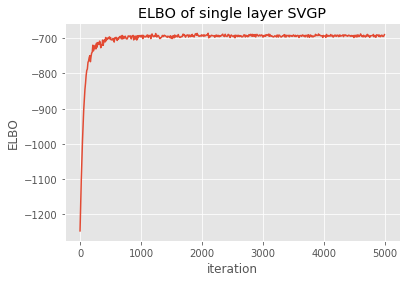

In [177]:
maxiter = ci_niter(5000)
logf, gradient = run_adam(m, maxiter)
plt.plot(np.arange(maxiter)[::10], logf)
plt.xlabel('iteration')
plt.ylabel('ELBO');
plt.title('ELBO of single layer SVGP')

In [ ]:
maxiter = ci_niter(5000)
logf, gradient = run_adam(m_500, maxiter)
plt.plot(np.arange(maxiter)[::10], logf)
plt.xlabel('iteration')
plt.ylabel('ELBO');
plt.title('ELBO of single layer SVGP with 500 inducing points')

/homes/rx220/env/lib/python3.7/site-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


-45808.79622304398
-31872.615028306922
-24294.089987270476
-16779.92869953575
-9347.66535263134
-6098.822234547962



Text(0.5, 1.0, 'ELBO of DGP')

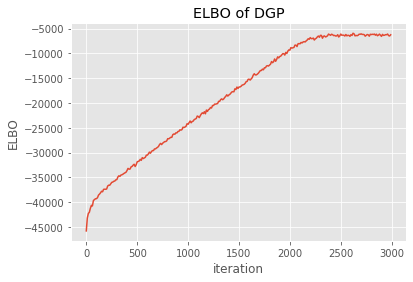

In [114]:
maxiter = ci_niter(3000)
logf_dgp2 = run_adam_dgp(dgp2, maxiter)
plt.plot(np.arange(maxiter)[::10], logf_dgp2)
plt.xlabel('iteration')
plt.ylabel('ELBO')
plt.title('ELBO of DGP')

/homes/rx220/env/lib/python3.7/site-packages/ipykernel_launcher.py:41: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


-48006.1338235975
-11726.586830404794
-10305.097137687793



Text(0.5, 1.0, 'ELBO of DGP2 ARD')

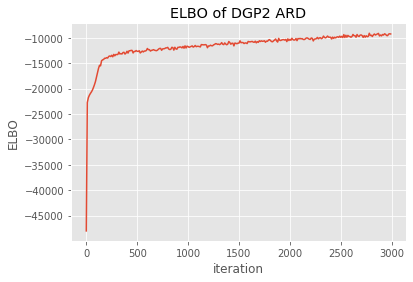

In [184]:
maxiter = ci_niter(3000)
logf_dgp2_ard, gradients2 = run_adam_dgp(dgp2_ard, maxiter)
plt.plot(np.arange(maxiter)[::10], logf_dgp2_ard)
plt.xlabel('iteration')
plt.ylabel('ELBO')
plt.title('ELBO of DGP2 ARD')

/homes/rx220/env/lib/python3.7/site-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


-80261.8875748818
-57391.407959215394
-42587.777982295804
-27692.273205846916
-12414.530155983592
-6197.882141755186
-6332.92073588464
-6045.067216948569
-6355.129021993692
-6464.592602999805



Text(0.5, 1.0, 'ELBO of DGP 3 layers')

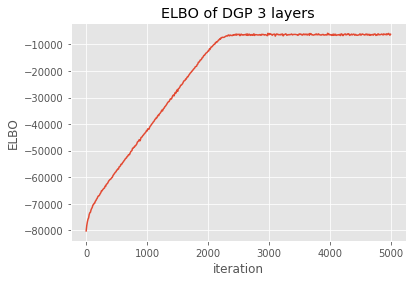

In [99]:
maxiter = ci_niter(5000)
logf_dgp3 = run_adam_dgp(dgp3, maxiter)
plt.plot(np.arange(maxiter)[::10], logf_dgp3)
plt.xlabel('iteration')
plt.ylabel('ELBO')
plt.title('ELBO of DGP 3 layers')

/homes/rx220/env/lib/python3.7/site-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


-44079.96284367353
-31883.86540088297
-24180.125182459928
-16299.146947923728
-9065.262193297656
-6520.907566658823



Text(0.5, 1.0, 'ELBO of DGP 3 layers')

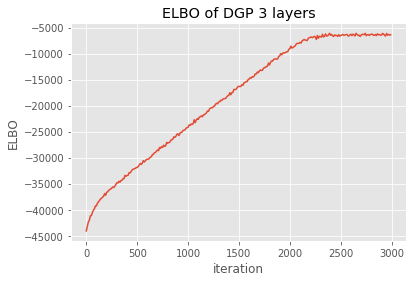

In [107]:
maxiter = ci_niter(3000)
logf_dgp3_50 = run_adam_dgp(dgp3_50, maxiter)
plt.plot(np.arange(maxiter)[::10], logf_dgp3_50)
plt.xlabel('iteration')
plt.ylabel('ELBO')
plt.title('ELBO of DGP 3 layers')

/homes/rx220/env/lib/python3.7/site-packages/ipykernel_launcher.py:41: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


-81044.91021865797
-17311.257979918868
-14778.364172292188
-12836.395461248314
-10970.997462176681
-9750.745201850154
-8482.302488916426
-7520.993700551355
-6697.408271115319
-6858.559059287978



Text(0.5, 1.0, 'ELBO of DGP with 3 layers using Adam')

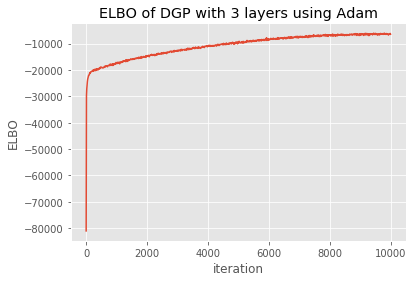

In [145]:
maxiter = ci_niter(10000)
logf_dgp3_adam, dgp3_gradients= run_adam_dgp(dgp3_adam, maxiter)
plt.plot(np.arange(maxiter)[::10], logf_dgp3_adam)
plt.xlabel('iteration')
plt.ylabel('ELBO')
plt.title('ELBO of DGP with 3 layers using Adam')

/homes/rx220/env/lib/python3.7/site-packages/ipykernel_launcher.py:41: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().
-107530.08718131564
-52754.44758766349
-50194.66938083587
-48146.709139756305
-46433.8098474302



Text(0.5, 1.0, 'ELBO of DGP')

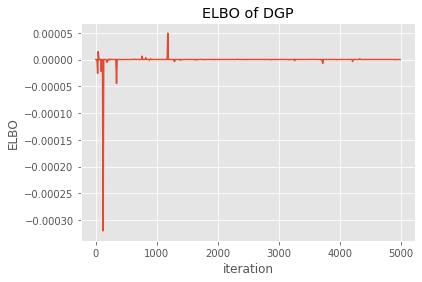

In [22]:
maxiter = ci_niter(5000)
logf_dgp3, dgp3_gradients= run_adam_dgp(dgp3, maxiter)
plt.plot(np.arange(maxiter)[::10], dgp3_gradients)
plt.xlabel('iteration')
plt.ylabel('ELBO')
plt.title('ELBO of DGP')

/homes/rx220/env/lib/python3.7/site-packages/ipykernel_launcher.py:41: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


-81044.91021865797
-17583.301182203206
-14631.96647388022
-12830.312884109542
-10800.900099712939
-9447.575895825808
-8464.246640228288
-7348.751724407532
-6708.602510749383
-5759.1380776932565
-5741.682040540742
-6221.637872317323
-5642.566679395728
-5673.872395317908
-5726.9326441801095
-5985.699196401129
-6062.950603559928
-6062.85114308014
-5851.066467240658
-6002.292947932987



Text(0.5, 1.0, 'ELBO of DGP3 ARD Adam')

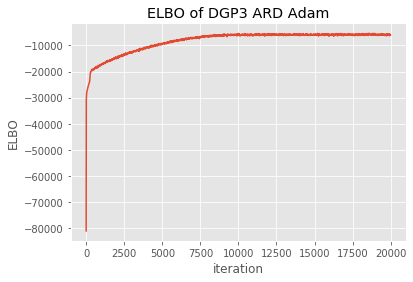

In [42]:
maxiter = ci_niter(20000)
logf3_adam, gradient = run_adam_dgp(dgp3_ard, maxiter)
plt.plot(np.arange(maxiter)[::10], logf3_adam)
plt.xlabel('iteration')
plt.ylabel('ELBO');
plt.title('ELBO of DGP3 ARD Adam')

/homes/rx220/env/lib/python3.7/site-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


-80991.43365125632
-57277.374255184586
-42069.56109302445
-27046.493902399106
-12090.214770462979
-6088.1342676883905
-5758.383480329671
-5872.799108930774
-6092.048727698301
-6293.433887429142



Text(0.5, 1.0, 'ELBO of DGP3 ARD NatGrad')

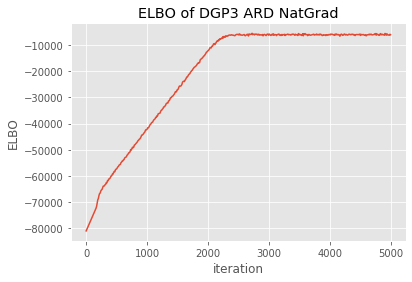

In [30]:
maxiter = ci_niter(5000)
logf3_natgrad = run_adam_dgp(dgp3_ard, maxiter)
plt.plot(np.arange(maxiter)[::10], logf3_natgrad)
plt.xlabel('iteration')
plt.ylabel('ELBO');
plt.title('ELBO of DGP3 ARD NatGrad')

Text(0, 0.5, 'ELBO')

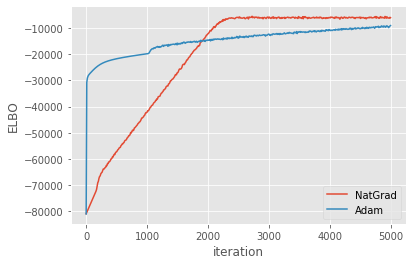

In [33]:
plt.plot(np.arange(maxiter)[::10], logf3_natgrad, label='NatGrad')
plt.plot(np.arange(maxiter)[::10], logf3_adam, label='Adam')
plt.legend(loc='lower right')
plt.xlabel('iteration')
plt.ylabel('ELBO')

/homes/rx220/env/lib/python3.7/site-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


-113804.57085955827
-83064.9507931269
-60098.819892506115
-37523.68349568642
-15441.14843274347
-6291.03468661289
-6381.600711730108
-6202.995064911882
-6547.011337155086
-6373.409283218059



Text(0.5, 1.0, 'ELBO of DGP 4 layers')

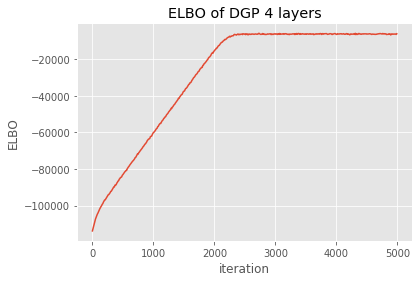

In [93]:
maxiter = ci_niter(5000)
logf_dgp4 = run_adam_dgp(dgp4, maxiter)
plt.plot(np.arange(maxiter)[::10], logf_dgp4)
plt.xlabel('iteration')
plt.ylabel('ELBO')
plt.title('ELBO of DGP 4 layers')

/homes/rx220/env/lib/python3.7/site-packages/ipykernel_launcher.py:41: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


-114083.68661371844
-23463.49674465834
-18912.07838132814
-15894.399978747913
-13475.003021865574
-11712.047855517143
-9639.242546749701
-7913.588958055517
-7427.158420979889
-6375.755392997444



Text(0.5, 1.0, 'ELBO of DGP with 4 layers using Adam')

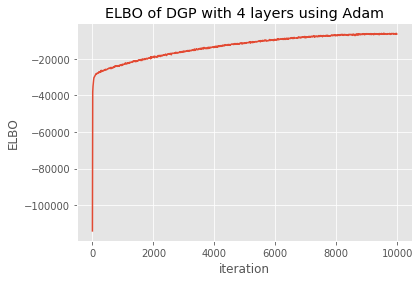

In [149]:
maxiter = ci_niter(10000)
logf_dgp4_adam, dgp4_gradients= run_adam_dgp(dgp4_adam, maxiter)
plt.plot(np.arange(maxiter)[::10], logf_dgp4_adam)
plt.xlabel('iteration')
plt.ylabel('ELBO')
plt.title('ELBO of DGP with 4 layers using Adam')

In [24]:
def assess_model_sgp(model, X_batch, Y_batch):
    m, v = model.predict_y(X_batch)
    l = model.predict_log_density([X_batch, Y_batch])
    a = ((m>0.5).numpy().astype(int) == Y_batch.astype(int))
    return l, a

S = 100
def assess_model_dgp(model, X_batch, Y_batch):
    m, v = model.predict_y(X_batch, S)
    l = model.predict_density(X_batch, Y_batch, S)
    m = np.average(m,axis=0)
    a = ((m>0.5).astype(int) == Y_batch.astype(int))
    return l, a

In [25]:
def batch_assess(model, assess_model, X, Y):
    n_batches = max(int(len(X)/1000), 1)
    lik, acc = [], []
    for X_batch, Y_batch in zip(np.split(X, n_batches), np.split(Y, n_batches)):
        l, a = assess_model(model, X_batch, Y_batch)
        lik.append(l)
        acc.append(a)
    lik = np.concatenate(lik, 0)
    acc = np.array(np.concatenate(acc, 0), dtype=float)
    return np.average(lik), np.average(acc)

## SGP

In [178]:
l, a = batch_assess(m, assess_model_sgp, x_test, y_test)
print('sgp test lik: {:.4f}, test acc {:.4f}'.format(l, a))

sgp test lik: -0.6575, test acc 0.7212


In [169]:
l, a = batch_assess(m_500, assess_model_sgp, x_test, y_test)
print('sgp test lik: {:.4f}, test acc {:.4f}'.format(l, a))

sgp test lik: -0.6541, test acc 0.7287


## DGP using Adam

In [115]:
l, a = batch_assess(dgp2, assess_model_dgp, x_test, y_test)
print('dgp2 test lik: {:.4f}, test acc {:.4f}'.format(l, a))

dgp2 test lik: -0.4817, test acc 0.7674


In [146]:
l, a = batch_assess(dgp3_adam, assess_model_dgp, x_test, y_test)
print('dgp3_adam test lik: {:.4f}, test acc {:.4f}'.format(l, a))

dgp3_adam test lik: -0.4643, test acc 0.7747


In [150]:
l, a = batch_assess(dgp4_adam, assess_model_dgp, x_test, y_test)
print('dgp4 test lik: {:.4f}, test acc {:.4f}'.format(l, a))

dgp4 test lik: -0.4650, test acc 0.7766


## DGP using NatGrad

In [100]:
l, a = batch_assess(dgp3, assess_model_dgp, x_test, y_test)
print('dgp3 test lik: {:.4f}, test acc {:.4f}'.format(l, a))

dgp3 test lik: -0.4795, test acc 0.7698


In [108]:
l, a = batch_assess(dgp3_50, assess_model_dgp, x_test, y_test)
print('dgp3_50 test lik: {:.4f}, test acc {:.4f}'.format(l, a))

dgp3_50 test lik: -0.4815, test acc 0.7682


In [95]:
l, a = batch_assess(dgp4, assess_model_dgp, x_test, y_test)
print('dgp4 test lik: {:.4f}, test acc {:.4f}'.format(l, a))

dgp4 test lik: -0.4809, test acc 0.7692


## DGP ARD

In [187]:
l, a = batch_assess(dgp2_ard, assess_model_dgp, x_test, y_test)
print('dgp2_ard test lik: {:.4f}, test acc {:.4f}'.format(l, a))

dgp2_ard test lik: -0.4646, test acc 0.7751


In [43]:
l, a = batch_assess(dgp3_ard, assess_model_dgp, x_test, y_test)
print('dgp3_ard test lik: {:.4f}, test acc {:.4f}'.format(l, a))

dgp3_ard test lik: -0.4620, test acc 0.7748


In [35]:
l, a = batch_assess(dgp3_ard, assess_model_dgp, x_test, y_test)
print('dgp3_ard_natgrad test lik: {:.4f}, test acc {:.4f}'.format(l, a))

dgp3_ard_natgrad test lik: -0.4666, test acc 0.7729
